In [1]:
import numpy as np
import pandas as pd

# Step 1: Generate synthetic dataset
np.random.seed(42)
num_samples = 2000  # Number of samples

# Random sensor values simulating piezoelectric breathing signals
sensor_values = np.random.uniform(0.1, 2.5, size=num_samples)

# Assign categories based on sensor value ranges
categories = []
for value in sensor_values:
    if 1.0 <= value <= 1.5:
        categories.append(0)  # Normal
    elif value < 1.0:
        categories.append(1)  # Shallow
    elif value > 1.5 and value <= 2.0:
        categories.append(2)  # Deep
    elif value > 2.0:
        categories.append(3)  # Apnea
    else:
        categories.append(4)  # Irregular

# Create a DataFrame
data = pd.DataFrame({'Sensor Value': sensor_values, 'Category': categories})

# Save the dataset to a CSV file
data.to_csv('piezoelectric_breathing_dataset.csv', index=False)

print("Dataset saved to 'piezoelectric_breathing_dataset.csv'")

Dataset saved to 'piezoelectric_breathing_dataset.csv'


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load dataset
data = pd.read_csv('piezoelectric_breathing_dataset.csv')

# Preprocess the data
sensor_values = data['Sensor Value'].values
categories = data['Category'].values

# Generate synthetic images based on sensor values
X = np.array([np.full((128, 128, 1), value / 2.5) for value in sensor_values])  # Normalize by max value (2.5)
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB

y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Piezoelectric breathing data loaded and preprocessed.")

Piezoelectric breathing data loaded and preprocessed.


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.6637 - loss: 0.9486 - val_accuracy: 0.9200 - val_loss: 0.4920
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.9304 - loss: 0.4458 - val_accuracy: 0.9425 - val_loss: 0.3688
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.9370 - loss: 0.3434 - val_accuracy: 0.9600 - val_loss: 0.3036
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.9623 - loss: 0.2879 - val_accuracy: 0.9675 - val_loss: 0.2572
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.9785 - loss: 0.2439 - val_accuracy: 0.9775 - val_loss: 0.2304
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9641 - loss: 0.2243 - val_accuracy: 0.9700 - val_loss: 0.2131
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.9739 - loss: 0.2026 - val_accuracy: 0.9700 - val_loss: 0.2018
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9641 - loss: 0.1862 - val_accu

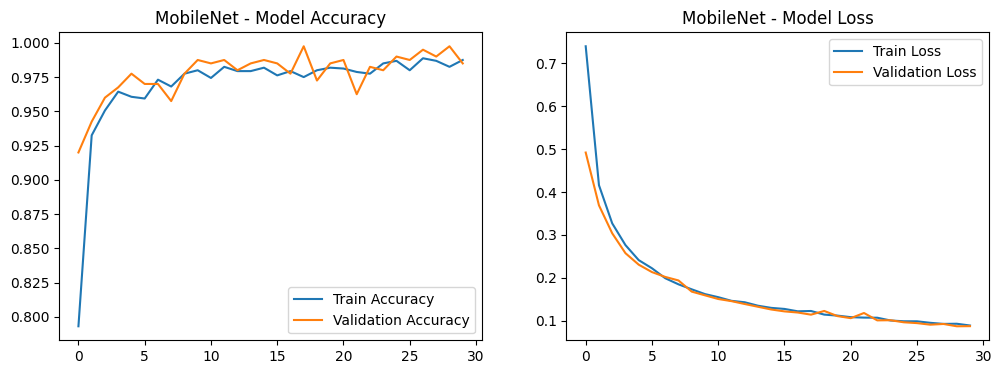

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# Step 1: Build the MobileNetV2 model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')  # 5 classes: Normal, Shallow, Deep, Apnea, Irregular
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 2: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,  # Adjust epochs based on training needs
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save('piezoelectric_breathing_model_mobilenet.h5')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet - Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNet - Model Loss')
plt.legend()

plt.show()


In [4]:
import tensorflow as tf
import numpy as np

# Step 1: Load the trained model
model = tf.keras.models.load_model('piezoelectric_breathing_model_mobilenet.h5')

# Function to predict breathing pattern
def predict_breathing_pattern(sensor_value):
    # Normalize the input sensor value
    sensor_normalized = sensor_value / 2.5  # Normalize based on dataset range

    # Generate a dummy image
    X_input = np.full((128, 128, 1), sensor_normalized)
    X_input_resized = np.repeat(X_input, 3, axis=-1)  # Convert to RGB
    X_input_resized = np.expand_dims(X_input_resized, axis=0)  # Add batch dimension

    # Predict the category
    predictions = model.predict(X_input_resized)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map the predicted class to its label
    class_labels = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular']
    predicted_label = class_labels[predicted_class]

    return predicted_label, predictions

# Input sensor value
sensor_value = float(input("Enter a piezoelectric sensor value: "))
predicted_label, probabilities = predict_breathing_pattern(sensor_value)
print(f"Sensor Value: {sensor_value} -> Predicted: {predicted_label} (Probabilities: {probabilities})")


Enter a piezoelectric sensor value:  508


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sensor Value: 508.0 -> Predicted: Apnea (Probabilities: [[1.8276350e-09 4.0946996e-10 1.3093345e-09 1.0000000e+00 8.1819600e-09]])


In [5]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('piezoelectric_breathing_model_mobilenet.h5')


In [17]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv('piezoelectric_breathing_dataset.csv')
sensor_values = data['Sensor Value'].values
categories = data['Category'].values

# Generate synthetic images
X = np.array([np.full((128, 128, 1), value / 2.5) for value in sensor_values])  # Normalize by max value (2.5)
X = np.repeat(X, 3, axis=-1)
y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# Generate predictions for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Get the unique class labels present in y_test
unique_classes = np.unique(y_test)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular'][:len(unique_classes)]

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\n MobileNet - Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step
Confusion Matrix:
[[ 86   0   0   0]
 [  1 141   0   0]
 [  0   0  81   0]
 [  0   0   0  91]]

 MobileNet - Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99        86
     Shallow       1.00      0.99      1.00       142
        Deep       1.00      1.00      1.00        81
       Apnea       1.00      1.00      1.00        91

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Precision: 0.9975
Recall: 0.9975
F1 Score: 0.9975


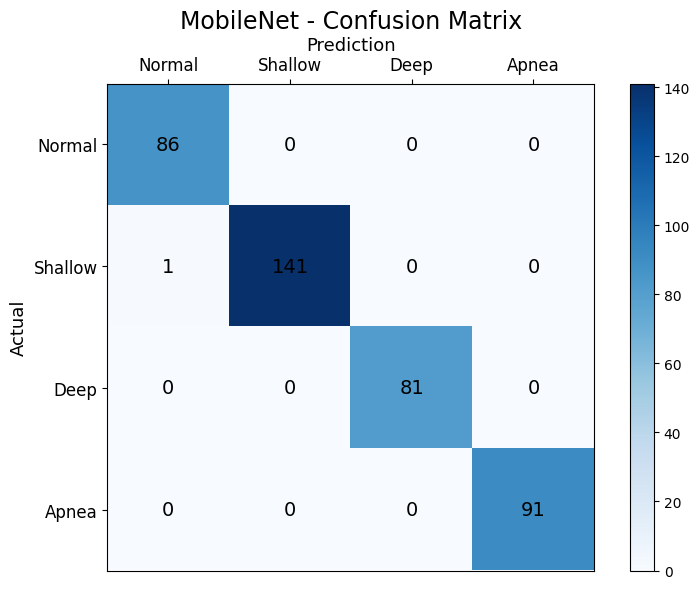

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class labels dynamically based on unique classes in y_test
unique_classes = np.unique(y_test)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular'][:len(unique_classes)]

# Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')  # Use the 'Blues' colormap
fig.colorbar(cax)

# Annotate the confusion matrix with the counts
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

# Set axis labels and ticks
ticks = range(len(target_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(target_names, fontsize=12)
ax.set_yticklabels(target_names, fontsize=12)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Set axis labels and title
ax.set_xlabel('Prediction', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)
plt.title('MobileNet - Confusion Matrix', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()
